In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
plt.rcParams['figure.figsize'] = 12, 6

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127


In [4]:
df_pr = df[(df.table_id == 'day')& (df.source_id == 'NorESM2-LM')]
len(df_pr.table_id)

69

In [8]:
def load_pr_data(expt_id,vble_id):
    """
    Load 3hr precip data for given source and expt ids
    """
    uri = df_pr[(df_pr.experiment_id == expt_id) & (df_pr.variable_id == vble_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [9]:
hist_tmin = load_pr_data('historical', 'tasmin').sel(lat=slice(4, 10)).sel(lon=slice(33,39)).load()
hist_tmax = load_pr_data('historical', 'tasmax').sel(lat=slice(4, 10)).sel(lon=slice(33,39)).load()

ssp245_tmin = load_pr_data('ssp245', 'tasmin').sel(lat=slice(4, 10)).sel(lon=slice(33,39)).load()
ssp245_tmax = load_pr_data('ssp245', 'tasmax').sel(lat=slice(4, 10)).sel(lon=slice(33,39)).load()

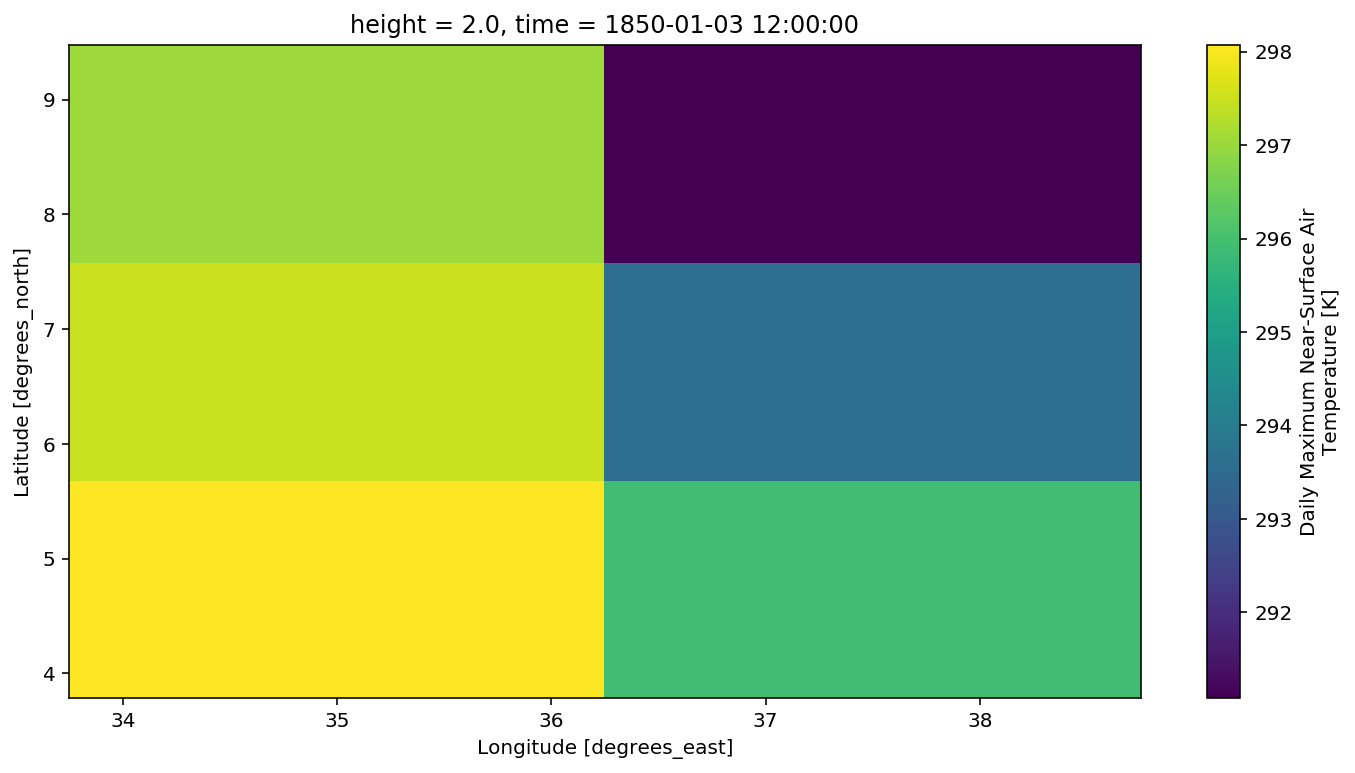

In [11]:
#plt.figure(figsize=(16,8))
# ax = plt.axes()
hist_tmax.tasmax.isel(time=2).sel(lat=slice(4, 10)).sel(lon=slice(32,39)).plot()
# plt.xlim(34,40)
# omo.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 1)
# plt.show()
# hist.isel(time = 0).plot()

In [24]:
dir_ls = ['SW', 'SE', 'W', 'E', 'NW', 'NW']


def createDict(dataSet, vble, dictName):
    i = 0
    for lat in dataSet.lat:
        for lon in dataSet.lon:
            ts = dataSet[vble].sel(lat=lat).sel(lon=lon)
            dictName[dir_ls[i]] = ts
            i +=1

# dir_ls = ['SW', 'SE', 'W', 'E', 'NW', 'NW']
# ls = {}
# i = 0
# for lat in hist_tmin.lat:
#     for lon in hist_tmin.lon:
#         pr_ts = hist.pr.sel(lat=lat).sel(lon=lon)
#         ls[dir_ls[i]] = pr_ts
#         i+=1
        

In [25]:
h_tmin = {}
h_tmax = {}
s_tmin = {}
s_tmax = {}
createDict(hist_tmin, 'tasmin', h_tmin)
createDict(ssp245_tmin, 'tasmin', s_tmin)
createDict(hist_tmax, 'tasmax', h_tmax)
createDict(ssp245_tmax, 'tasmax', s_tmax)


In [47]:
def plotVals(l, title):
    for item in dir_ls:
        df = pd.DataFrame({'date':l[item].time, 'pr':l[item]})
        df['date'] =  df['date'].astype(str)
        df['date'] = pd.to_datetime(df['date'])
        df = df.groupby(df['date'].dt.year).mean()
        plt.plot(df.index, df.pr, label = item)

    plt.legend()
    plt.title(title)
    plt.show()
    

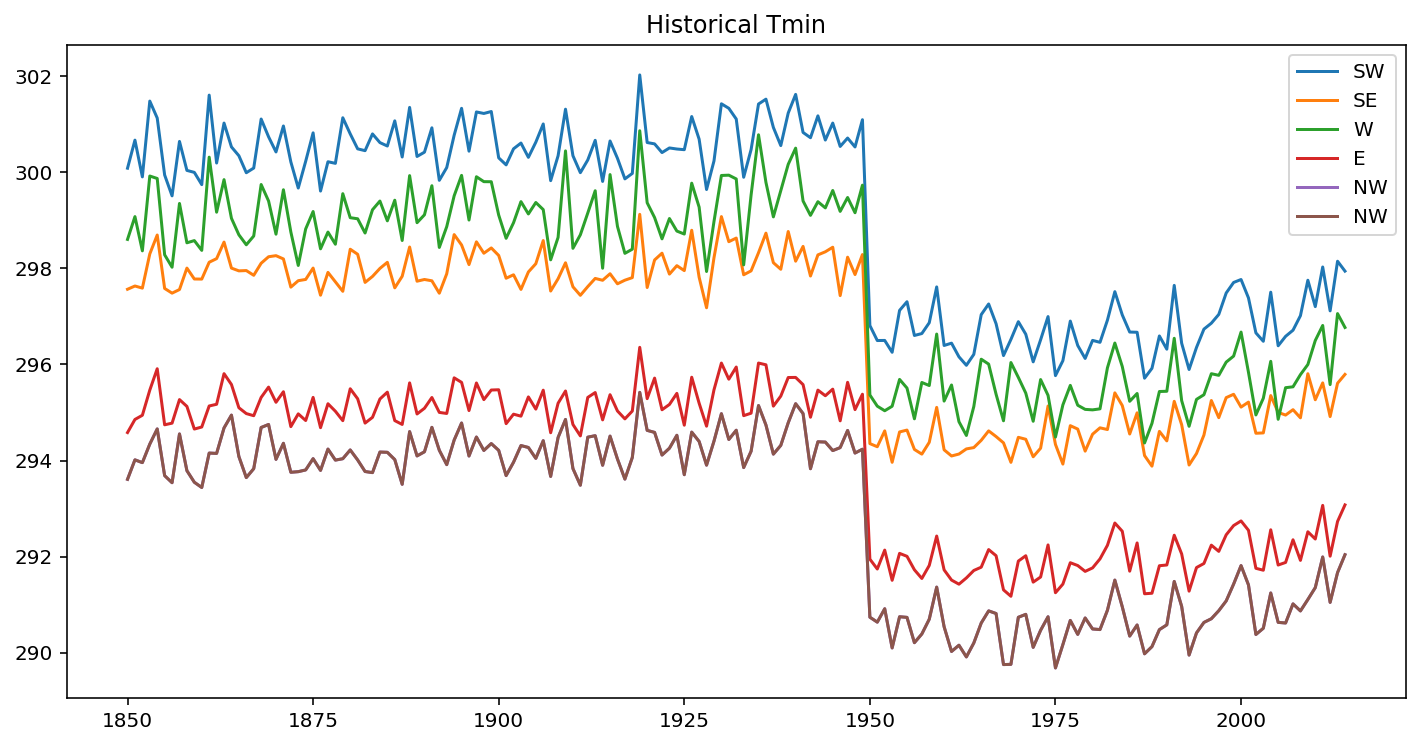

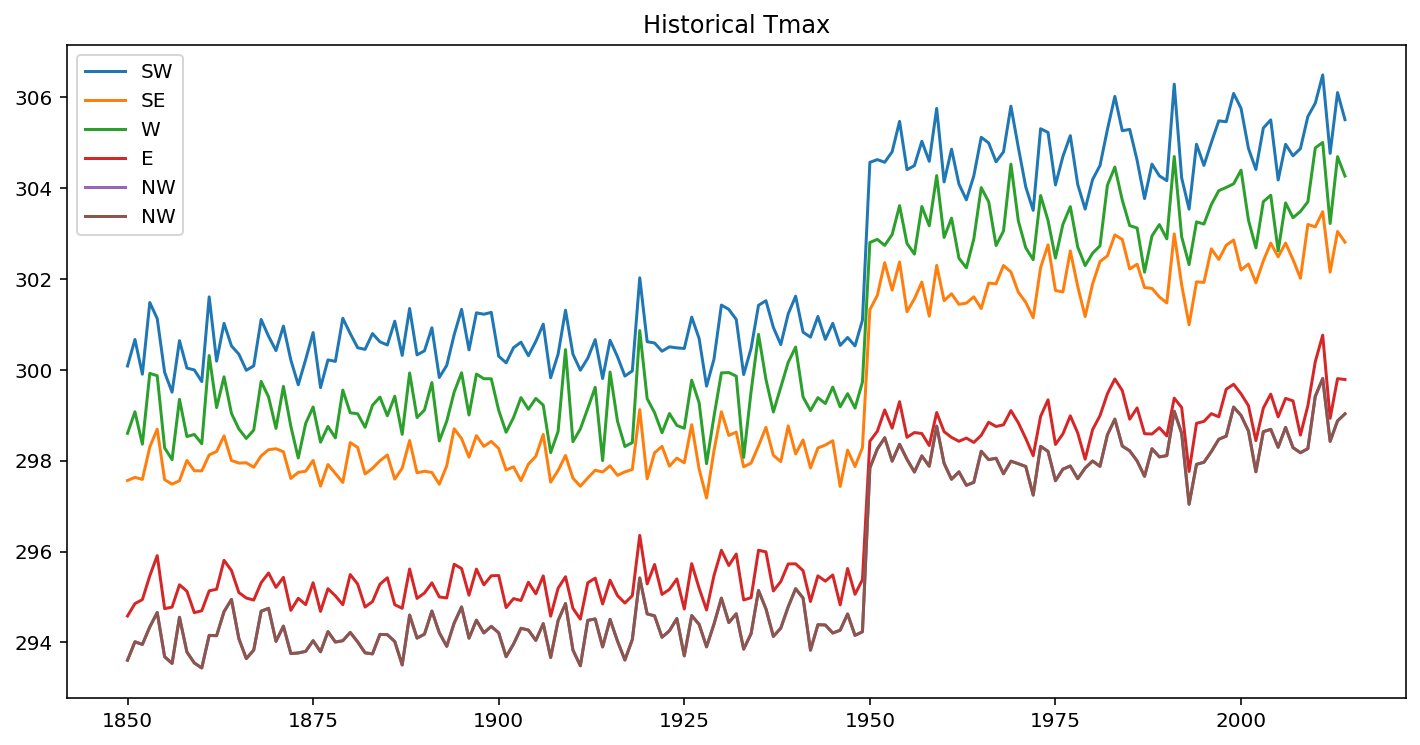

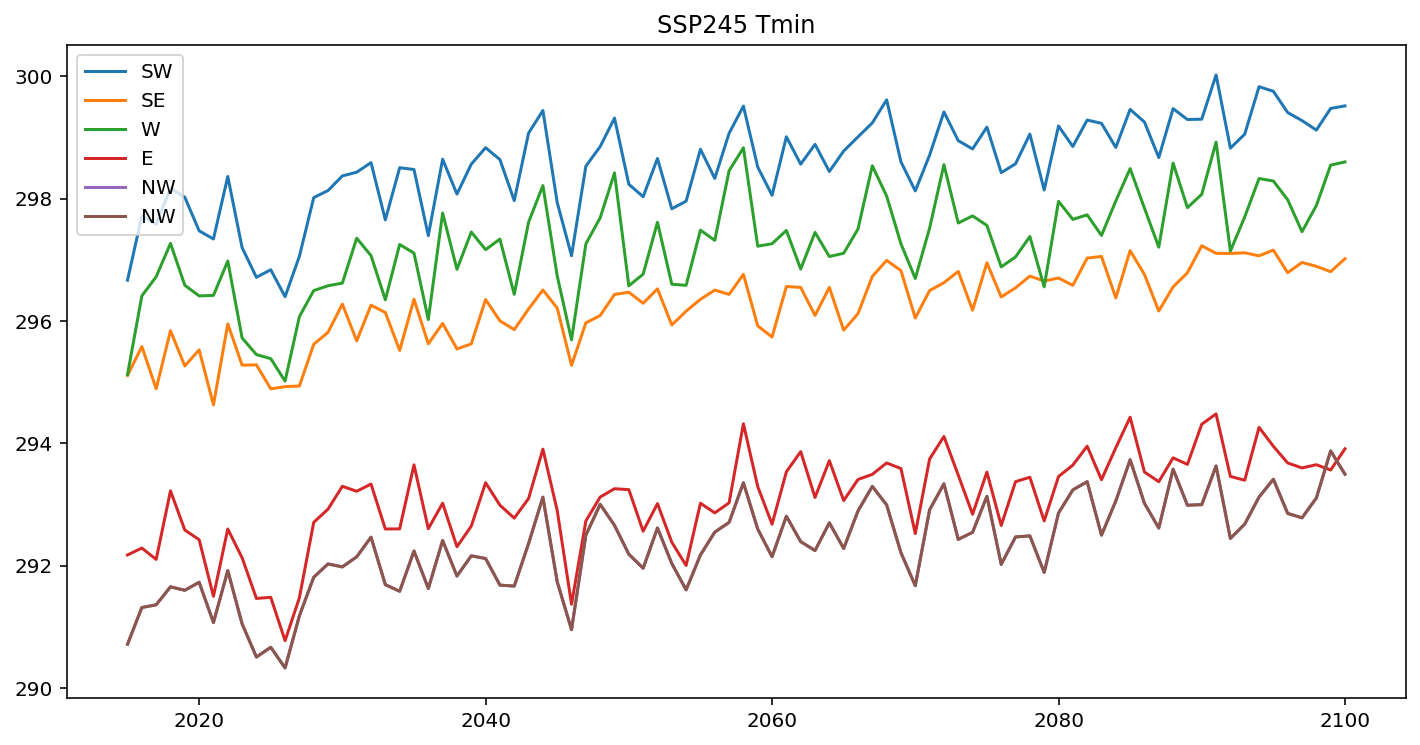

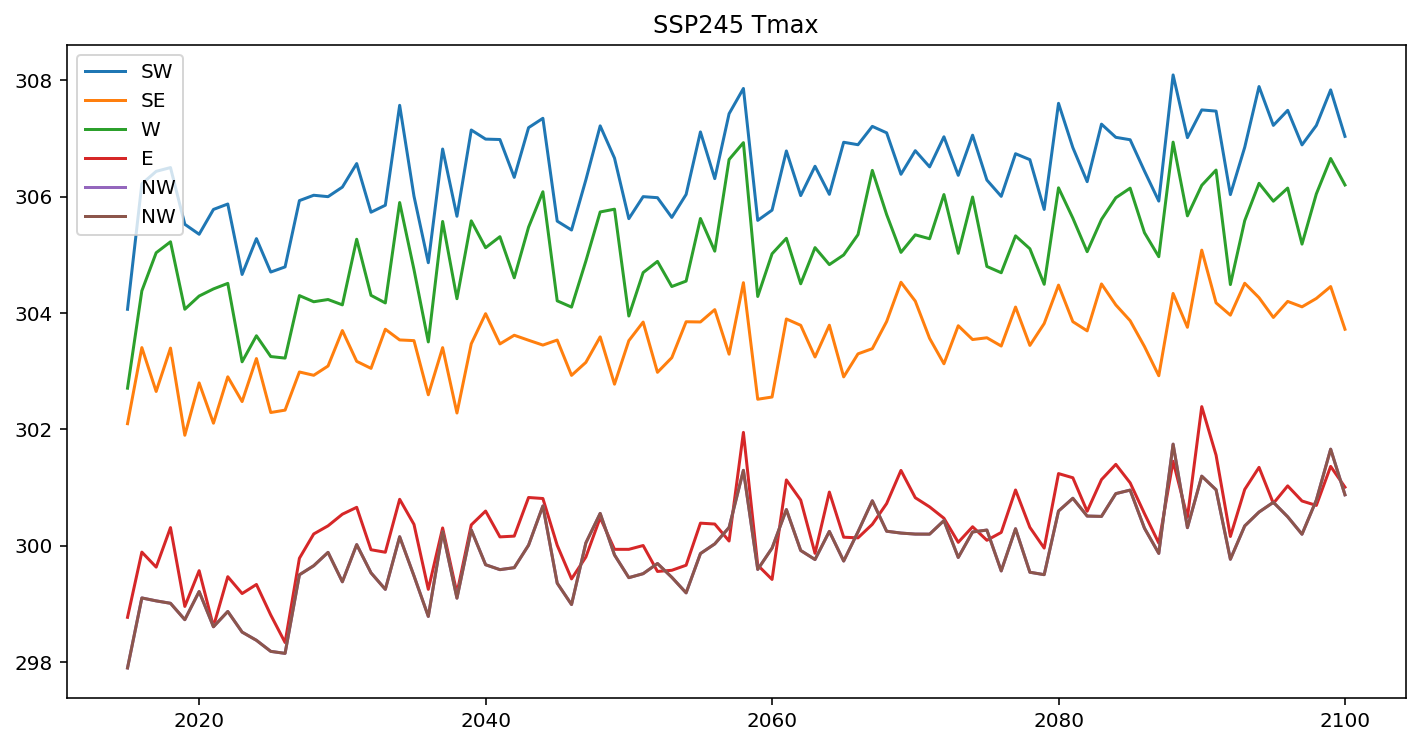

In [49]:
plotVals(h_tmin, "Historical Tmin")
plotVals(h_tmax, "Historical Tmax")
plotVals(s_tmin, "SSP245 Tmin")
plotVals(s_tmax, "SSP245 Tmax")

In [52]:
def writeCSVs(l_min, l_max, tframe):
    for item in dir_ls:
        df = pd.DataFrame({'date':l_min[item].time, 'tmin':l_min[item], 'tmax': l_max[item]})
        df['date'] =  df['date'].astype(str)
        df['date'] = pd.to_datetime(df['date'])
        df.to_csv("NorESM2-LM-" + tframe + "-" + item + ".csv")

In [53]:
writeCSVs(h_tmin, h_tmax, "hist")
writeCSVs(s_tmin, s_tmax, "ssp245")